Title: Taking the Guesswork out of Bouncing Balls   
Date: 2023-02-10   
Category: Tech   
Tags: Simulations, Python   
Slug: guesswork-bouncing-balls   
Summary: A complicated way to explain game mechanics to a computer   
Status: draft   

Games are complicated.

They have a lot of stuff you can do! You can [click on things](http://orteil.dashnet.org/cookieclicker/), [crash space ships](https://www.kerbalspaceprogram.com/), [play pinball](https://blogs.windows.com/windowsexperience/2015/10/09/pinball-fx2-windows-10-edition-is-now-available/) or even [bounce a ball back and forth](https://www.ponggame.org/).

Rarely-- and it is a cursed moment when it happens-- I'm called on to design some part of a game. This is really hard because [game design is extremely difficult](https://www.gamedeveloper.com/design/-quot-the-door-problem-quot-of-game-design). But, also, because I am bad at video games. I tune everything to be way too easy, because _I_ have to be the first play tester, and I tend to tune stuff that _I_ find fun.

I was in the middle of one of these struggles when I saw a presentation of Yegeta Zeleke's paper on [analyzing and modeling action games](https://dl.acm.org/doi/pdf/10.1145/3337722.3337757). I didn't really understand the presentation at the time, but I couldn't stop thinking about it. Fast forward years later, and here we are.

I want to be clear: game mechanics modeling and simulation _does not_ replace good design. When the models are good, they can work as a lens to help shine light on certain corner cases. They will not make something good for you. Programs are focused and narrow tools: do not make the [tech bro mistake](https://nypost.com/2022/06/24/suspended-google-engineer-claims-sentient-ai-bot-has-hired-a-lawyer/) and think they are anything more than that.

### So, Let's Dive In

The paper is a case study in applying a math thing called a Hybrid Dynamical System to [Flappy Bird](https://kotaku.com/the-flappy-bird-fiasco-1519938266). What's a Hybrid Dynamical System?

I'm a "learn by doing" kind of person; I wanted to try and implement one to find out. I tend to start with Python and move to lower level languages later. I'm comfortable in Python and most of the time, this means my bugs are logic bugs and not implementation bugs.

The core concept here is that we can break a system (read as: game) into two parts:  

1. **The continuous part**: this part is things like jump arcs, amount of power produced by a power plant in an RTS, car drifting, and starship thrust. These parts of the game change continuously while they're happening, and are often handled by a physics engine. When a game is operating this way, it's _flowing_, and these changes are called _flows_.  

2. **The discrete part**: this part is sudden, sharp changes in a game, switching from one mode to another. Characters are very often modeled as a collection of sharp switches-- you're not punching, you hit the punch button, and then suddenly you are! When a game is operating this way, it's _jumping_, and these changes are called _jumps_.

It's then just a uh, simple, question of modeling all the flows, modeling all the jumps, and then some logic to say when to jump and which flow to be in.

### Let's start with something more simple than Pong

The proverbial first example with Hybrid Dynamic Systems is a bouncing ball. To start, I need the ball's state, which changes over time. To keep this very simple, I won't even model horizontal position (left / right): let's only care about vertical position (up / down). And, since I want to change vertical position over time, vertical velocity[^1].

[^1]: using `y` as my vertical axis, rather than `z`. This is [A Thing](https://forums.autodesk.com/t5/fusion-360-manufacture/why-is-y-up-instead-of-z-by-default/td-p/7226258), and something I didn't think to hard about-- I can always refactor this to `z` later. If you're much happier with `y` as your depth axis, go for it.

In [120]:
from dataclasses import dataclass
@dataclass
class State:
    y_pos: float # vertical position
    y_vel: float # vertical velocity

state = State(y_pos=1.0, y_vel=1.0)
print(state)

State(y_pos=1.0, y_vel=1.0)


So, when does a bouncing ball jump? It starts by falling-- seems pretty continuous-- then hits the ground, then suddenly springs back up. That contact with the ground is a jump, a sudden switch in state. The ball's velocity was going down, now in a instant, it's going up![^2]

[^2]: I know almost no physics, but I'm sure that in reality, this is all a continuous system and there are some Adult equations to calculate how potential energy gets... released? as the ball springs up. Whatever, close enough.

What might that look like in code? Lets also throw in a constant [restitution coefficient](https://en.wikipedia.org/wiki/Coefficient_of_restitution), so we can lose some energy as we bounce to make it feel a little more real.

In [121]:
def jump(state:State) -> State:
    # reduce the velocity by multiplying it by a less-than-one restitution coefficient
    # flip the direction by also multiplying by a negative one.
    # the restitution coefficient is 0.5 here
    state.y_vel = -0.5 * state.y_vel
    # return!
    return state

state = State(y_pos=1.0, y_vel=1.0)
# Python's pass by reference here so I really don't need this assignment
# but I think it helps illustrate what's happening
print(f"Before jumping:\t{state}") # actually the old state
state = jump(state)
print(f"After jumping:\t{state}")

Before jumping:	State(y_pos=1.0, y_vel=1.0)
After jumping:	State(y_pos=1.0, y_vel=-0.5)


"Woah, slow down there cowboy," you say, in my head. "How does the computer know when to trigger a jump?"

Ah! Right. If we flip the velocity before we hit the ground, we'll just go more up. That's not how gravity works. The gamers would be very mad at our lack of attention to realism in Ball Sim 2023[^3]. Well, we can just use another function to tell us if we should jump or not, call it uh, 

[^3]: Gonna need to workshop this title

In [122]:
def jump_check(state:State) -> bool:
    if state.y_pos <= 0 and state.y_vel < 0:
        # collision detection? What's that? Everyone knows the ground is at position 0 :)
        # hills, like birds, are not real
        # anyway, we be jumpin if we hit the ground and we still have negative velocity (so we'd go more into the ground.
        return True
    else:
        # otherwise keep flowing
        return False

air_state = State(y_pos=1.0, y_vel=-1)
print(f"Jump from {air_state}?\t{jump_check(air_state)}")
ground_state = State(y_pos=0.0, y_vel=-1)
print(f"Jump from {ground_state}?\t{jump_check(ground_state)}")
below_ground_state = State(y_pos=-0.5, y_vel=-1)
print(f"Jump from {below_ground_state}?\t{jump_check(below_ground_state)}")

Jump from State(y_pos=1.0, y_vel=-1)?	False
Jump from State(y_pos=0.0, y_vel=-1)?	True
Jump from State(y_pos=-0.5, y_vel=-1)?	True


That covers jumps-- there's a function, `jump` to say "this is how we do the instantaneous state change" and another function `jump_check` that says "it's time to jump". Flows are similar! There's a function to run to say how we're flowing (`flow`), and a function to say if we should be flowing or not (`flow_check`). The... well, the check function gets a little silly with our ball example:

In [123]:
def flow_check(state: State) -> bool:
    """This one is a little silly, I know"""
    return True

air_state = State(y_pos=1.0, y_vel=-1)
print(f"Flow from {air_state}?\t{flow_check(air_state)}")
ground_state = State(y_pos=0.0, y_vel=-1)
print(f"Flow from {ground_state}?\t{flow_check(ground_state)}")
below_ground_state = State(y_pos=-0.5, y_vel=-1)
print(f"Flow from {below_ground_state}?\t{flow_check(below_ground_state)}")

Flow from State(y_pos=1.0, y_vel=-1)?	True
Flow from State(y_pos=0.0, y_vel=-1)?	True
Flow from State(y_pos=-0.5, y_vel=-1)?	True


I know. This feels like I'm pranking you. I'm not trying to. Sometimes, its just like this. Our system is so simple that it's _always_ flowing. Sure, it jumps sometimes, but that happens in a single instant, and gravity never stops, so. There are times in video games when we want to stop applying constant forces ([coyote time](https://gamerant.com/celeste-coyote-time-mechanic-platforming-impact-hidden-mechanics/)), so this is less silly later.

Now, to actually calculate flows... well, we're not gonna do it by hand. Remember that a flows are an ever changing, ever evolving thing over time, and math has a tool for that: a derivative. Our flow needs to be a function that takes in our state and returns that state's derivative with respect to time.

Ok, so, the derivative of position is the velocity, right? Velocity describes how position changes over time. The derivative of velocity is acceleration... which we'll pretend is a [negative constant](https://en.wikipedia.org/wiki/Gravitational_acceleration) thanks to gravity of 9.81.

In [124]:
from dataclasses import dataclass
@dataclass
class StateDerivative:
    """ Using a separate data class to help identify when my data is a state
        and when it's the derivative of a state.
    """
    derivative_position: float
    derivative_velocity: float
 
def flow(state:State) -> StateDerivative:
    """The derivative of positions is velocity.
       The derivative of velocity is going to be negative acceleration from gravity
    """
    return StateDerivative(
        derivative_position=state.y_vel,
        derivative_velocity=-9.81
    )

state = State(y_pos=1.0, y_vel=1.0)
state_derivative = flow(state)
# hoping that this return helps format this output ok
print(f"State {state} flows over time\naccording to {state_derivative}")

State State(y_pos=1.0, y_vel=1.0) flows over time
according to StateDerivative(derivative_position=1.0, derivative_velocity=-9.81)


So we have a little system! Four equations that all have the following calling signatures:

In [125]:
import inspect # inspect is a standard library that lets us inspect our code at run time.
               # there's a whole aside here about reflection and self-modifying code
print(f"Flow signature: {inspect.signature(flow)}")
print(f"Flow check signature: {inspect.signature(flow_check)}")
print(f"Jump signature: {inspect.signature(jump)}")
print(f"Jump check signature: {inspect.signature(jump_check)}")

Flow signature: (state: __main__.State) -> __main__.StateDerivative
Flow check signature: (state: __main__.State) -> bool
Jump signature: (state: __main__.State) -> __main__.State
Jump check signature: (state: __main__.State) -> bool


Ok, so `__main__` might be weird there for you, but hey it's our functions![^3] Tada! That's a model baybee. You heard it here first folks, all action games are just four functions.

[^3]: `__main__` is the "main" Python module. When you don't have an entry point, i.e. in a notebook or REPL, `__main__` is where the function you define live. Otherwise, they live in the module you say they live in, which is typically the file you wrote them in [^4]
[^4]: it does get [more complicated than this](https://docs.python.org/3.11/tutorial/modules.html). Don't @ me.

### Simulations are how we get useful stuff from models

But uh, how do we use these four equations? We want to simulate the model for a given start state. We can actually do this analytically, no machine learning or complicated statistics required here! Because we're coming up with simulation results deterministically, its sometimes said that we "solve" the model.

Because a `flow` is a function that takes in a state and returns a derivative, it falls under a class known as an Ordinary Differential Equation, or ODE. This is a fairly dense branch of mathematics, but there exist methods to solve for ODEs! If you give an ODE Solver a function like `flow`, a start time, a start state and some constraints like "solve until `end_time`", you can get the states (along with times) for a `flow` from the start time to end time. This is called the "initial value problem" (IVP).

This post isn't going to go into writing your own ODE Solver[^5]. I just used `scipy`'s off the shelf one. I need to tweak the model a little bit. [The documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) says that (paraphrasing):  

> The ODE function must only have two parameters: `t`, a floating point number for time and `y`, and "array_like" where each element correspond to state property. Also, the function needs to return an "array_like" of the same size as `y` where each element is `y[element]`'s derivative.

Fine.

[^5]: Future Blit here-- I will eventually need to get into the weeds of writing my own ODE Solver, because the off-the-shelf ones don't have the features I will eventually need.

In [126]:
from typing import Tuple
from collections import namedtuple

# named tuples are tuples, but I can refer to each position by name
# this won't perfectly work, because scipy is gonna strip all this information when we're inside the
# flow function but it at least makes the constructor a little nicer
State = namedtuple('State', ['y_pos', 'y_vel'])
StateDerivative = namedtuple('StateDerivative', ['derivative_position', 'derivative_velocity'])

def flow(time: float, state: Tuple[float, float]) -> Tuple[float, float]:
    # we'll say that state[0] is position and state[1] is velocity
    return StateDerivative(
         # remember the derivative of position is velocity, so the derivative of state[0] is state[1].
         # Not the most intuitive
        derivative_position=state[1],
        derivative_velocity=-9.81
    )

state = State(y_pos=1.0, y_vel=1.0)
state_derivative = flow(0.0, state) # the exact time doesn't matter yet, but we'll need it in a second
print(f"State {state} flows over time\naccording to {state_derivative}")

State State(y_pos=1.0, y_vel=1.0) flows over time
according to StateDerivative(derivative_position=1.0, derivative_velocity=-9.81)


And then to use this thing:

In [127]:
from scipy import integrate
# we need to provide a start time, an end time and a state to start from
cur_state = State(y_pos=2.0, y_vel=0.0) # two, uh, units off the ground, no starting velocity seems ok
cur_time = 0.0 # start at the start
end_time = 1.0 # and we'll go for uh. one. uh. time unit

# the good stuff
ode_sol = integrate.solve_ivp(
    flow, # our flow function! It returns a derivative!
    # the current time is the start time! Solve from right now until as far forward as we want to solve
    (cur_time, end_time),
    cur_state,
)
if ode_sol.status == -1:
    print(f"Oh, no, solver failed! {ode_sol.message}")
for time, state in zip(ode_sol.t, ode_sol.y.T):
    # doing a little data translation (get the transpose [T] of the y values [aka state])
    # pair them with a similarly lengthed iterable, t [aka times], using zip(...)
    state_string_repr = [f"{val:0.04f}" for val in state] # some tricks for printing this more nicely
                                                          # it won't hold up in a court of law, but,
    print(f"State at {time:0.04f}:  {state_string_repr}")

State at 0.0000:  ['2.0000', '0.0000']
State at 0.0001:  ['2.0000', '-0.0010']
State at 0.0011:  ['2.0000', '-0.0110']
State at 0.0113:  ['1.9994', '-0.1109']
State at 0.1132:  ['1.9372', '-1.1104']
State at 1.0000:  ['-2.9050', '-9.8100']


Everything looks _ok_ until we get to that last value. W... what happened there. I need to set some tolerances on my solver-- you can kinda see that it did a "one, two, skip a few" approach-- we get a bunch of work before the first tenth of a second and then suddenly, we jump to the end of the solution.

The reasons for this are... a lot, and based on how the underlying solver math works, which could be a fun topic for another day! Anyway, let's set the solver to work at a fixed time interval.

In [128]:
# providing the start state again, but no notes this time.
cur_state = State(y_pos=2.0, y_vel=0.0)
cur_time = 0.0
end_time = 1.0

ode_sol = integrate.solve_ivp(
    flow,
    (cur_time, end_time),
    cur_state,
    # ✨ New! ✨ All points in the solution should only ever be a tenth of a second apart.
    max_step=0.01,
    # while we're here, let's set some tolerances
    atol=1e-6, # stay within this number of decimal places
    rtol=1e-6, # stay within this number of digits
)
if ode_sol.status == -1:
    print(f"Oh, no, solver failed! {ode_sol.message}")
for time, state in zip(ode_sol.t, ode_sol.y.T):
    state_string_repr = [f"{val:0.04f}" for val in state]
    print(f"State at {time:0.04f}:  {state_string_repr}")

State at 0.0000:  ['2.0000', '0.0000']
State at 0.0100:  ['1.9995', '-0.0981']
State at 0.0200:  ['1.9980', '-0.1962']
State at 0.0300:  ['1.9956', '-0.2943']
State at 0.0400:  ['1.9922', '-0.3924']
State at 0.0500:  ['1.9877', '-0.4905']
State at 0.0600:  ['1.9823', '-0.5886']
State at 0.0700:  ['1.9760', '-0.6867']
State at 0.0800:  ['1.9686', '-0.7848']
State at 0.0900:  ['1.9603', '-0.8829']
State at 0.1000:  ['1.9509', '-0.9810']
State at 0.1100:  ['1.9406', '-1.0791']
State at 0.1200:  ['1.9294', '-1.1772']
State at 0.1300:  ['1.9171', '-1.2753']
State at 0.1400:  ['1.9039', '-1.3734']
State at 0.1500:  ['1.8896', '-1.4715']
State at 0.1600:  ['1.8744', '-1.5696']
State at 0.1700:  ['1.8582', '-1.6677']
State at 0.1800:  ['1.8411', '-1.7658']
State at 0.1900:  ['1.8229', '-1.8639']
State at 0.2000:  ['1.8038', '-1.9620']
State at 0.2100:  ['1.7837', '-2.0601']
State at 0.2200:  ['1.7626', '-2.1582']
State at 0.2300:  ['1.7405', '-2.2563']
State at 0.2400:  ['1.7175', '-2.3544']
S

Well, call me silly. Turns out the solver was right the whole time-- still it's nice to be able to _see_ that.

Well, this does highlight another problem-- our hight ended up being less than zero. But, that makes sense: we haven't told the solver when to stop. We know that we should stop flowing when `jump_check` is `true`, but our solver, if we only give it our `flow` function, doesn't know that. We can use an event function to help here.

Event functions also take in the state and time, like `flow`, but return a single scalar. We can then ask the solver to do some extra work to figure out exactly at what time an event function returns 0, and we can ask for the solver to stop solving when this occurs. We'll stop solving when we're ready to jump! But, it means that our `jump_check` function also needs a little refactor to work like an event function:

In [129]:
def jump_check(time: float, state:Tuple[float, float]) -> int:
    if state[0] <= 0 and state[1] < 0:
        # stop flowing when we're ready to jump-- it's a "0 crossing" of our flow system
        return 0
    else:
        # otherwise keep flowing
        return 1

jump_check.terminal = True # you can assign attributes to functions in Python
                           # it's not my favorite, but this is how we'll have the solver stop solving
                           # when this function returns 0

# same set of values to check as before, let's confirm the numbers do what we want.
air_state = State(y_pos=1.0, y_vel=-1)
print(f"Jump from {air_state}?\t{jump_check(0.0, air_state)}")
ground_state = State(y_pos=0.0, y_vel=-1)
print(f"Jump from {ground_state}?\t{jump_check(0.0, ground_state)}")
below_ground_state = State(y_pos=-0.5, y_vel=-1)
print(f"Jump from {below_ground_state}?\t{jump_check(0.0, below_ground_state)}")

Jump from State(y_pos=1.0, y_vel=-1)?	1
Jump from State(y_pos=0.0, y_vel=-1)?	0
Jump from State(y_pos=-0.5, y_vel=-1)?	0


Rad. And while we're here, lets update our other functions to have a consistent API. Sometimes getting an `int` and sometimes getting a `bool` is how programmers go crazy.

In [130]:
def flow_check(time: float, state:Tuple[float, float]) -> int:
    # as before, we're always flowing
    return 0

def jump(time: float, state:Tuple[float, float]) -> Tuple[float, float]:
    # tuples are immutable, so we gotta make a new one
    # that's probably a thing to think about w.r.t. optimizations
    new_state = tuple([
        state[0],
        -0.5 * state[1]
    ])
    return new_state

print(f"Flow signature: {inspect.signature(flow)}")
print(f"Flow check signature: {inspect.signature(flow_check)}")
print(f"Jump signature: {inspect.signature(jump)}")
print(f"Jump check signature: {inspect.signature(jump_check)}")

Flow signature: (time: float, state: Tuple[float, float]) -> Tuple[float, float]
Flow check signature: (time: float, state: Tuple[float, float]) -> int
Jump signature: (time: float, state: Tuple[float, float]) -> Tuple[float, float]
Jump check signature: (time: float, state: Tuple[float, float]) -> int


Ok, let's put it all together:

In [131]:
from typing import List, Any, Callable

@dataclass
class HybridSystem():
    """ Collect all our functions into one structure for ease of being able to remember things later.
    """
    flow: Callable
    flow_check: Callable
    jump: Callable
    jump_check: Callable

@dataclass
class SystemParameters():
    """ Setting up some stopping points: what our time interval to solve over should be, and the maximum
        number of jumps we want to have before we call it quits.
    """
    start_time: float
    end_time: float
    max_jumps: int

def solve_system(system:HybridSystem, params:SystemParameters, start_state:State) -> List[Any]:
    solution:List[Any] = [] # gradual typing is neat!
    cur_time = 0.0
    number_of_jumps = 0
    state = start_state

    while (cur_time < params.end_time and number_of_jumps < params.max_jumps):
        if(system.flow_check(cur_time, state) == 0):
            ode_sol = integrate.solve_ivp(
                system.flow,
                (cur_time, params.end_time),
                state,
                events=[system.jump_check],
                max_step=0.01,
                atol=1e-6,
                rtol=1e-6
            )
            if ode_sol.status == -1:
                print(f"Solver failed with message: {ode_sol.message}")
                return solution
            for time, state in zip(ode_sol.t, ode_sol.y.T):
                solution.append((time, state))

            cur_time, state = solution[-1] # the last element in the solution is our new current state
    
        if (system.jump_check(cur_time, state) == 0): # a little backwards
            state = jump(cur_time, state)
            number_of_jumps += 1

    return solution

bouncing_ball_hybrid_system = HybridSystem(flow, flow_check, jump, jump_check)
bouncing_ball_params = SystemParameters(
    start_time=0.0,
    end_time=1.0,
    max_jumps=5
)
start_state = State(y_pos=2.0, y_vel=0.0)
solution = solve_system(bouncing_ball_hybrid_system, bouncing_ball_params, start_state)

for time, state in solution:
    state_string_repr = [f"{val:0.04f}" for val in state]
    print(f"State at {time:0.04f}:  {state_string_repr}")

State at 0.0000:  ['2.0000', '0.0000']
State at 0.0100:  ['1.9995', '-0.0981']
State at 0.0200:  ['1.9980', '-0.1962']
State at 0.0300:  ['1.9956', '-0.2943']
State at 0.0400:  ['1.9922', '-0.3924']
State at 0.0500:  ['1.9877', '-0.4905']
State at 0.0600:  ['1.9823', '-0.5886']
State at 0.0700:  ['1.9760', '-0.6867']
State at 0.0800:  ['1.9686', '-0.7848']
State at 0.0900:  ['1.9603', '-0.8829']
State at 0.1000:  ['1.9509', '-0.9810']
State at 0.1100:  ['1.9406', '-1.0791']
State at 0.1200:  ['1.9294', '-1.1772']
State at 0.1300:  ['1.9171', '-1.2753']
State at 0.1400:  ['1.9039', '-1.3734']
State at 0.1500:  ['1.8896', '-1.4715']
State at 0.1600:  ['1.8744', '-1.5696']
State at 0.1700:  ['1.8582', '-1.6677']
State at 0.1800:  ['1.8411', '-1.7658']
State at 0.1900:  ['1.8229', '-1.8639']
State at 0.2000:  ['1.8038', '-1.9620']
State at 0.2100:  ['1.7837', '-2.0601']
State at 0.2200:  ['1.7626', '-2.1582']
State at 0.2300:  ['1.7405', '-2.2563']
State at 0.2400:  ['1.7175', '-2.3544']
S

Well, that looks right... but is it? We could try and read the data and figure out exactly what happened, but it's probably easier to just graph it.

Instead of outputting this "nicely formatted" string to the console, a few quick modifications can have us write it to a `.csv` file that we can read in and chart later with `matplotlib` [^6].

[^6]: I'm skipping the graphing code for now-- it's a lot of boilerplate, and I want to someday I want to have a nicer publishing flow. That means it's future content, baybee.

In [132]:
import csv
from io import StringIO

bouncing_ball_hybrid_system = HybridSystem(flow, flow_check, jump, jump_check)
bouncing_ball_params = SystemParameters(0.0, 1.0, 5)
start_state = State(y_pos=2.0, y_vel=0.0)
solution = solve_system(bouncing_ball_hybrid_system, bouncing_ball_params, start_state)

# ✨ New! ✨ we want to write out to a csv rather than standard out
# revealing a little bit of how I write here, don't look too hard at this file path
with open("../tmp/bouncing_balls_output_data.csv", "w") as f:
    writer = csv.DictWriter(f=f, fieldnames=["time", "y_pos", "y_vel"])
    writer.writeheader()
    for time, state in solution:
        writer.writerow({
            "time": time,
            "y_pos": state[0], # unfortunately, all our nice names have been stripped,
            "y_vel": state[1]  # and we need to remember the ordering
        })


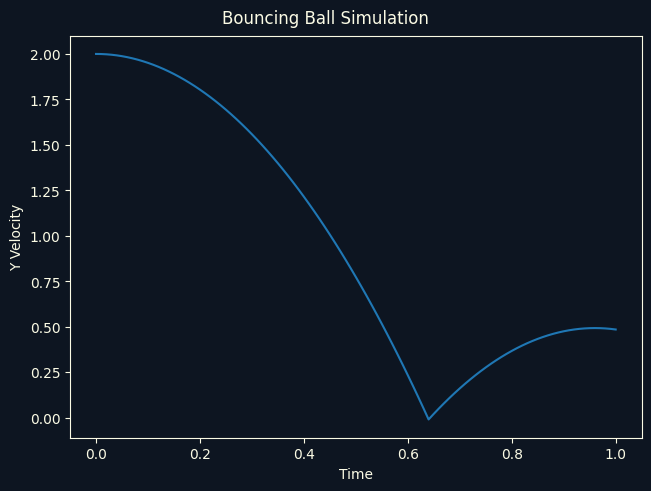

In [133]:
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET
from io import BytesIO
from typing import Dict

# setup
plt.rcParams['svg.fonttype'] = 'none'
ET.register_namespace("", "http://www.w3.org/2000/svg") #avoid NS collisions 

@dataclass
class SimData:
    """ Transforming our data a little bit. Matplotlib plays nicer with iterables
        for each dimension, rather than one iterable where each element is an array
    """
    time: List[float]
    y_pos: List[float]
    y_vel: List[float]

def read_sim_data(file:Path) -> SimData:
    """ Quick function to read in data from our CSV file
        and convert it to something matplotlib will enjoy playing with.
    """
    # a little clunky, a cleaner way to do this is with a default_factory
    # as part of the dataclass definition, but this gets the point across (I hope)
    data = SimData([], [], [])
    with open(file, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            data.time.append(float(row["time"]))
            data.y_pos.append(float(row["y_pos"]))
            data.y_vel.append(float(row["y_vel"]))
    
    return data

# MAIN FUNCTION THAT ACTUALLY DOES THE THING
data = read_sim_data(Path("../tmp/bouncing_balls_output_data.csv"))
fig = plt.figure(layout="constrained")
fig.suptitle("Bouncing Ball Simulation", color="#fbfbe5")
fig.set_facecolor("#0d1521")
ax = fig.add_subplot()

ax.set_facecolor("#0d1521")
ax.set_xlabel("Time")
ax.set_ylabel("Y Velocity")
ax.xaxis.label.set_color("#fbfbe5")
ax.yaxis.label.set_color("#fbfbe5")
ax.spines['top'].set_color("#fbfbe5")
ax.spines['left'].set_color("#fbfbe5")
ax.spines['right'].set_color("#fbfbe5")
ax.spines['bottom'].set_color("#fbfbe5")

ax.tick_params(axis='x', colors="#fbfbe5")    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors="#fbfbe5")  #setting up Y-axis tick color to black

lines = ax.plot(data.time, data.y_pos)

# ok, set an id so we can grab this information later
for line_idx, line in enumerate(lines):
    line.set_gid(f"line_{line_idx}")


# serialize to SVG
f = BytesIO()
plt.savefig(f, format="svg")

# create the XML ETree
tree, xmlid = ET.XMLID(f.getvalue())
defs = tree.find("defs", {"": "http://www.w3.org/2000/svg"})
if defs:
    css = ET.SubElement(defs, "style")
    css.set("type", "text/css")
    css.text = """.graph-line-1{
    stroke:#fbfbe5;
    stroke-width:1.5;
    stroke-linecap:square;
    fill:#0d1521;
    stroke-dasharray:140%;
    stroke-dashoffset:140%;
    animation-name:line-anim-1;
    animation-duration:5s;
    animation-timing-function:linear;
    animation-fill-mode:forwards;
    animation-iteration-count: 1;
}
@keyframes line-anim-1{
    from{
        stroke-dashoffset:140%;
    }
    to{
        stroke-dashoffset:0%;
    }
}"""
    
# TODO: update the metadata as we're animating this image
#http://purl.org/dc/dcmitype/MovingImage 
# inlining styles here, this'll probably get SPICY once I start to figure out animations
for line_idx in range(len(lines)):
    el = xmlid[f"line_{line_idx}"]
    # we actually want to overwrite certain keys on the _child_ path here
    for path in el:
        path.set("class", "graph-line-1")
        path.set("style", "")
    
    #    print(path)
    #    css_attrs = CSSStyle.from_str(path.get("style"))
    #    css_attrs.attrs["animation"] = "1s spin linear"
    #    css_attrs.attrs["stroke"] = "red"
    #    path.set("style", css_attrs.to_str())

ET.ElementTree(tree).write("./images/guesswork_bouncing_balls.svg")

![An animated graph of how the velocity of a bouncing ball changes over time-- it bounces less and less high! Woo!]({static}/images/guesswork_bouncing_balls.svg)

Hey, this looks pretty good! Alright, these are the basics-- so, how does Flappy Bird... flap?